<a href="https://colab.research.google.com/github/Alarmelmangai-K/master-thesis/blob/main/Multiclass_FSI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install xgboost
!pip install shap
!pip install lime
!pip install catboost
!pip install shap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=5a73a65f1d9bc8a2d8361ab904015e1635e09b297f7a02ea6c9510cd978c5efd
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.7 MB/s eta 0:00:00


In [ ]:
!pip install category_encoders


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.3 MB/s eta 0:00:00


In [ ]:
!wget https://ftp.ncbi.nlm.nih.gov/pub/clinvar/tab_delimited/variant_summary.txt.gz

--2025-09-18 22:23:32--  https://ftp.ncbi.nlm.nih.gov/pub/clinvar/tab_delimited/variant_summary.txt.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.11, 130.14.250.12, 130.14.250.13, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 383906063 (366M) [application/x-gzip]
Saving to: ‘variant_summary.txt.gz’

variant_summary.txt 100%[===================>] 366.12M  53.6MB/s    in 7.8s    

2025-09-18 22:23:40 (46.8 MB/s) - ‘variant_summary.txt.gz’ saved [383906063/383906063]



In [ ]:
import gzip
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lime
import scipy.special
import re
import warnings
warnings.filterwarnings('ignore')
import lime.lime_tabular
import xgboost as xgb
from xgboost import XGBClassifier
from lime.lime_tabular import LimeTabularExplainer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_classif #knn, kmeans
from sklearn.calibration import CalibratedClassifierCV #knn, kmeans
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.cluster import KMeans
from scipy.stats import f_oneway
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler

In [ ]:
file_path = "variant_summary.txt.gz"
columns = [
    'Type','GeneSymbol','Cytogenetic','ReviewStatus','Assembly',
    'ChromosomeAccession','Chromosome',
    'PositionVCF','NumberSubmitters','SCVsForAggregateGermlineClassification',
    'ClinicalSignificance'
]
df = pd.read_csv(file_path, sep="\t", usecols=columns)

major_classes = ['Pathogenic', 'Benign', 'Likely benign', 'Likely pathogenic']
df_binary = df[df['ClinicalSignificance'].isin(major_classes)]

min_count = df_binary['ClinicalSignificance'].value_counts().min()
df_binary_balanced = (
    df_binary.groupby("ClinicalSignificance", group_keys=False)
    .apply(lambda x: x.sample(n=min_count, random_state=42))
)

target_size = 10000
df_binary_reduced = (
    df_binary_balanced.groupby("ClinicalSignificance", group_keys=False)
    .apply(lambda x: x.sample(n=target_size, random_state=42))
)

print(df_binary_reduced['ClinicalSignificance'].value_counts())
X = df_binary_reduced.drop(columns=['ClinicalSignificance']).fillna("Unknown")
for col in X.columns:
    if X[col].dtype == 'object':
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))

y = df_binary_reduced['ClinicalSignificance']
le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


ClinicalSignificance
Benign               10000
Likely benign        10000
Likely pathogenic    10000
Pathogenic           10000
Name: count, dtype: int64
Train shape: (32000, 10)
Test shape: (8000, 10)


# **TREE BASED MODEL**

# XGBoost

In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    objective='multi:softprob',
    num_class=len(le_y.classes_),
    eval_metric='mlogloss',
    max_depth=6,
    learning_rate=0.3,
    n_estimators=100,
    use_label_encoder=False,
    random_state=42
)

In [ ]:
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred, target_names=le_y.classes_))

XGBoost Classification Report:
                    precision    recall  f1-score   support

           Benign       0.84      0.79      0.81      2000
    Likely benign       0.69      0.80      0.74      2000
Likely pathogenic       0.68      0.65      0.67      2000
       Pathogenic       0.71      0.67      0.69      2000

         accuracy                           0.73      8000
        macro avg       0.73      0.73      0.73      8000
     weighted avg       0.73      0.73      0.73      8000



In [ ]:
importances = xgb_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train.columns, 'XGB_BuiltIn': importances})

print("\n XGBoost Built-in Feature Importance:")
for feature, score in zip(importance_df['Feature'], importance_df['XGB_BuiltIn']):
    print(f"{feature}: {score:.6f}")


📊 XGBoost Built-in Feature Importance:
Type: 0.344803
GeneSymbol: 0.040304
Assembly: 0.021989
ChromosomeAccession: 0.031766
Chromosome: 0.033770
Cytogenetic: 0.033935
ReviewStatus: 0.169366
NumberSubmitters: 0.060700
PositionVCF: 0.039090
SCVsForAggregateGermlineClassification: 0.224277


In [ ]:
perm_result = permutation_importance(
    estimator=xgb_model,
    X=X_test,
    y=y_test,
    scoring='accuracy',
    n_repeats=10,
    random_state=42
)
perm_df = pd.DataFrame({
    'Feature': X_train.columns,
    'PermutationImportance': perm_result.importances_mean
})
print("\n Permutation Importance (XGBClassifier):")
for feature, score in zip(perm_df['Feature'], perm_df['PermutationImportance']):
    print(f"{feature}: {score:.6f}")


📊 Permutation Importance (XGBClassifier):
Type: 0.087375
GeneSymbol: 0.019263
Assembly: -0.001900
ChromosomeAccession: 0.000112
Chromosome: -0.001375
Cytogenetic: 0.003925
ReviewStatus: 0.044687
NumberSubmitters: 0.025750
PositionVCF: 0.015850
SCVsForAggregateGermlineClassification: 0.380350


In [ ]:
X_test_subset = X_test.iloc[:500]
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test_subset)
shap_mean_abs = np.abs(shap_values.values).mean(axis=(0, 2))
shap_df = pd.DataFrame({
    'Feature': X_train.columns,
    'SHAP_MeanAbs_500': shap_mean_abs
})
print ("\n XGBoost SHAP MEAN ABSOLUTE")
print(shap_df)

 98%|===================| 1957/2000 [00:28<00:00]       

                                  Feature  SHAP_MeanAbs_500
0                                    Type          0.320192
1                              GeneSymbol          0.118109
2                                Assembly          0.016960
3                     ChromosomeAccession          0.054743
4                              Chromosome          0.035686
5                             Cytogenetic          0.075372
6                            ReviewStatus          0.194959
7                        NumberSubmitters          0.182855
8                             PositionVCF          0.104035
9  SCVsForAggregateGermlineClassification          1.225529


In [ ]:
X_sample = X_test.sample(n=500, random_state=42)
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_sample)
mean_abs_shap = np.mean(np.abs(shap_values.values), axis=(0,2))
shap_df = pd.DataFrame({
    'Feature': X_train.columns,
    'MeanAbsSHAP': mean_abs_shap
}).sort_values(by='MeanAbsSHAP', ascending=False)
print("\n XGBOOST Mean Absolute Shap")
print(shap_df)


 99%|===================| 1976/2000 [00:25<00:00]       


 XGBOOST Mean Absolute Shap
                                  Feature  MeanAbsSHAP
9  SCVsForAggregateGermlineClassification     0.973037
0                                    Type     0.402800
6                            ReviewStatus     0.161217
7                        NumberSubmitters     0.143957
1                              GeneSymbol     0.127654
8                             PositionVCF     0.112074
5                             Cytogenetic     0.076205
3                     ChromosomeAccession     0.057199
4                              Chromosome     0.033077
2                                Assembly     0.015925


In [ ]:
feature_names = list(X_train.columns)
sample_indices = np.random.choice(len(X_test), size=500, replace=False)
X_sample = X_test.iloc[sample_indices]
y_sample = y_test[sample_indices]
y_sample_idx = np.array([np.where(le_y.classes_ == le_y.inverse_transform([y])[0])[0][0]
                         if np.ndim(y)==0 else y for y in y_sample])
def predict_proba_lime(data_array):
    dmatrix = xgb.DMatrix(data_array, feature_names=feature_names)
    return model.predict(dmatrix)
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=feature_names,
    class_names=list(le_y.classes_),
    mode='classification'
)
feature_importances = np.zeros(len(feature_names))
for i in range(len(X_sample)):
    exp = explainer.explain_instance(
        data_row=X_sample.iloc[i].values,
        predict_fn=predict_proba_lime)
    exp_map = exp.as_map()
    pred_class = y_pred[sample_indices[i]]
    if pred_class in exp_map:
        for feature_idx, importance in exp_map[pred_class]:
            feature_importances[feature_idx] += abs(importance)
feature_importances /= len(X_sample)
lime_df = pd.DataFrame({
    'Feature': feature_names,
    'MeanAbsLIME': feature_importances
}).sort_values(by='MeanAbsLIME', ascending=False)
print("\n XGBOOST Aggregated LIME Feature Importance")
print(lime_df)



 XGBOOST Aggregated LIME Feature Importance
                                  Feature  MeanAbsLIME
0                                    Type     0.033370
6                            ReviewStatus     0.020898
9  SCVsForAggregateGermlineClassification     0.014902
7                        NumberSubmitters     0.014316
8                             PositionVCF     0.003414
1                              GeneSymbol     0.003217
3                     ChromosomeAccession     0.002352
5                             Cytogenetic     0.001891
4                              Chromosome     0.001854
2                                Assembly     0.001371


# Random Forest

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42
)

In [ ]:
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print("\n Random Forest Classification Report\n", classification_report(y_test, y_pred, target_names=le_y.classes_))


 Random Forest Classification Report
                    precision    recall  f1-score   support

           Benign       0.62      0.72      0.67      2000
    Likely benign       0.53      0.78      0.63      2000
Likely pathogenic       0.60      0.20      0.30      2000
       Pathogenic       0.61      0.62      0.62      2000

         accuracy                           0.58      8000
        macro avg       0.59      0.58      0.55      8000
     weighted avg       0.59      0.58      0.55      8000



In [ ]:
importance = rf_model.feature_importances_
sorted_importance = sorted(zip(X_train.columns, importance), key=lambda x: x[1], reverse=True)
print("\n Random Forest Built-in Feature Importance:\n")
for feature, score in sorted_importance:
    print(f"{feature}: {score:.4f}")


 Random Forest Built-in Feature Importance:

SCVsForAggregateGermlineClassification: 0.3887
Type: 0.3326
ReviewStatus: 0.1354
NumberSubmitters: 0.0839
PositionVCF: 0.0245
GeneSymbol: 0.0156
Cytogenetic: 0.0095
Chromosome: 0.0049
ChromosomeAccession: 0.0046
Assembly: 0.0004


In [ ]:
sample_indices = np.random.choice(len(X_test), size=int(0.2 * len(X_test)), replace=False)
X_test_sample = X_test.iloc[sample_indices]
y_test_sample = y_test[sample_indices]
perm_importance = permutation_importance(
    rf_model, X_test_sample, y_test_sample, n_repeats=10, random_state=42
)
print("\n Random Forest Permutation Importance:\n")
for i in perm_importance.importances_mean.argsort()[::-1]:
    print(f"{X_test.columns[i]}: {perm_importance.importances_mean[i]:.4f}")


 Random Forest Permutation Importance:

SCVsForAggregateGermlineClassification: 0.1954
Type: 0.1252
ReviewStatus: 0.0301
NumberSubmitters: 0.0134
PositionVCF: 0.0033
Chromosome: 0.0029
Assembly: 0.0007
GeneSymbol: 0.0004
Cytogenetic: -0.0001
ChromosomeAccession: -0.0008


In [ ]:
X_sample = X_test.sample(n=100, random_state=42)
explainer = shap.Explainer(rf_model, X_train)
shap_values = explainer(X_sample)
mean_abs_shap = np.mean(np.abs(shap_values.values), axis=(0,2))
shap_df = pd.DataFrame({
    'Feature': X_train.columns,
    'MeanAbsSHAP': mean_abs_shap
}).sort_values(by='MeanAbsSHAP', ascending=False)
print("\n Random Forest Mean Absolute Shap")
print(shap_df)


 Random Forest Mean Absolute Shap
                                  Feature  MeanAbsSHAP
9  SCVsForAggregateGermlineClassification     0.062160
0                                    Type     0.061355
6                            ReviewStatus     0.026338
7                        NumberSubmitters     0.021363
8                             PositionVCF     0.004544
1                              GeneSymbol     0.002214
5                             Cytogenetic     0.001701
4                              Chromosome     0.001659
3                     ChromosomeAccession     0.001413
2                                Assembly     0.000094


In [ ]:
feature_names = list(X_train.columns)
sample_indices = np.random.choice(len(X_test), size=100, replace=False)
X_sample = X_test.iloc[sample_indices]
y_sample = y_test[sample_indices]
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=feature_names,
    class_names=list(le_y.classes_),
    mode='classification'
)
feature_importances = np.zeros(len(feature_names))
for i in range(len(X_sample)):
    exp = explainer.explain_instance(
        data_row=X_sample.iloc[i].values,
        predict_fn=rf_model.predict_proba,
        num_features=len(feature_names)
    )
    exp_map = exp.as_map()
    pred_class = y_pred[sample_indices[i]]
    if pred_class in exp_map:
        for feature_idx, importance in exp_map[pred_class]:
            feature_importances[feature_idx] += abs(importance)
feature_importances /= len(X_sample)
lime_df = pd.DataFrame({
    'Feature': feature_names,
    'MeanAbsLIME': feature_importances
}).sort_values(by='MeanAbsLIME', ascending=False)
print("\nRandom Forest Aggregated LIME Feature Importance:")
print(lime_df)


Random Forest Aggregated LIME Feature Importance:
                                  Feature  MeanAbsLIME
0                                    Type     0.070171
9  SCVsForAggregateGermlineClassification     0.028414
7                        NumberSubmitters     0.024212
6                            ReviewStatus     0.018582
1                              GeneSymbol     0.000838
4                              Chromosome     0.000755
5                             Cytogenetic     0.000740
3                     ChromosomeAccession     0.000617
2                                Assembly     0.000550
8                             PositionVCF     0.000526


# Decision Tree

In [ ]:
dt_model = DecisionTreeClassifier(
    criterion="gini",
    max_depth=10,
    random_state=42
)
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)

In [ ]:
print("\n Decision Tree Classification Report\n", classification_report(y_test, y_pred, target_names=le_y.classes_))


 Decision Tree Classification Report
                    precision    recall  f1-score   support

           Benign       0.87      0.75      0.80      2000
    Likely benign       0.66      0.78      0.71      2000
Likely pathogenic       0.63      0.64      0.64      2000
       Pathogenic       0.68      0.63      0.66      2000

         accuracy                           0.70      8000
        macro avg       0.71      0.70      0.70      8000
     weighted avg       0.71      0.70      0.70      8000



In [ ]:
dt_importances = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": dt_model.feature_importances_
}).sort_values(by="Importance", ascending=False)
print("\nDecision Tree Feature Importances:")
print(dt_importances)


Decision Tree Feature Importances:
                                  Feature  Importance
9  SCVsForAggregateGermlineClassification    0.738355
0                                    Type    0.143057
6                            ReviewStatus    0.036338
1                              GeneSymbol    0.025798
7                        NumberSubmitters    0.017626
8                             PositionVCF    0.017562
5                             Cytogenetic    0.011823
3                     ChromosomeAccession    0.006282
4                              Chromosome    0.002721
2                                Assembly    0.000438


In [ ]:
sample_indices = np.random.choice(len(X_test), size=int(0.2 * len(X_test)), replace=False)
X_test_sample = X_test.iloc[sample_indices]
y_test_sample = y_test[sample_indices]
perm_importance = permutation_importance(
    dt_model, X_test_sample, y_test_sample, n_repeats=10, random_state=42
)
print("\n Decision tree Permutation Importance:\n")
for i in perm_importance.importances_mean.argsort()[::-1]:
    print(f"{X_test.columns[i]}: {perm_importance.importances_mean[i]:.4f}")


 Decision tree Permutation Importance:

SCVsForAggregateGermlineClassification: 0.3875
Type: 0.1083
ReviewStatus: 0.0473
NumberSubmitters: 0.0161
PositionVCF: 0.0114
GeneSymbol: 0.0057
Cytogenetic: 0.0029
ChromosomeAccession: 0.0018
Chromosome: 0.0016
Assembly: 0.0000


In [ ]:
X_sample = X_test.sample(n=100, random_state=42)
explainer = shap.Explainer(dt_model, X_train)
shap_values = explainer(X_sample)
mean_abs_shap = np.mean(np.abs(shap_values.values), axis=(0,2))
shap_df = pd.DataFrame({
    'Feature': X_train.columns,
    'MeanAbsSHAP': mean_abs_shap
}).sort_values(by='MeanAbsSHAP', ascending=False)
print("\n Decision tree Mean Absolute Shap")
print(shap_df)


 Decision tree Mean Absolute Shap
                                  Feature  MeanAbsSHAP
9  SCVsForAggregateGermlineClassification     0.186873
0                                    Type     0.058097
6                            ReviewStatus     0.024143
7                        NumberSubmitters     0.015921
1                              GeneSymbol     0.010895
8                             PositionVCF     0.007699
5                             Cytogenetic     0.005069
3                     ChromosomeAccession     0.003898
4                              Chromosome     0.001254
2                                Assembly     0.000503


In [ ]:
feature_names = list(X_train.columns)
sample_indices = np.random.choice(len(X_test), size=100, replace=False)
X_sample = X_test.iloc[sample_indices]
y_sample = y_test[sample_indices]
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=feature_names,
    class_names=list(le_y.classes_),
    mode='classification'
)
feature_importances = np.zeros(len(feature_names))
for i in range(len(X_sample)):
    exp = explainer.explain_instance(
        data_row=X_sample.iloc[i].values,
        predict_fn=dt_model.predict_proba,
        num_features=len(feature_names)
    )
    exp_map = exp.as_map()
    pred_class = y_pred[sample_indices[i]]
    if pred_class in exp_map:
        for feature_idx, importance in exp_map[pred_class]:
            feature_importances[feature_idx] += abs(importance)
feature_importances /= len(X_sample)
lime_df = pd.DataFrame({
    'Feature': feature_names,
    'MeanAbsLIME': feature_importances
}).sort_values(by='MeanAbsLIME', ascending=False)
print("\nDecision tree Aggregated LIME Feature Importance:")
print(lime_df)


Decision tree Aggregated LIME Feature Importance:
                                  Feature  MeanAbsLIME
0                                    Type     0.068564
9  SCVsForAggregateGermlineClassification     0.040176
7                        NumberSubmitters     0.015922
6                            ReviewStatus     0.005257
3                     ChromosomeAccession     0.002172
4                              Chromosome     0.002113
8                             PositionVCF     0.002051
5                             Cytogenetic     0.001797
1                              GeneSymbol     0.001749
2                                Assembly     0.001623


# CAT Model

In [ ]:
cat_model = CatBoostClassifier(random_state=42, verbose=0)
cat_model.fit(X_train, y_train)
y_pred_cat = cat_model.predict(X_test)
print("=== CatBoost Classification Report ===")
print(classification_report(y_test, y_pred_cat))

=== CatBoost Classification Report ===
              precision    recall  f1-score   support

           0       0.85      0.77      0.81      2000
           1       0.68      0.80      0.73      2000
           2       0.67      0.66      0.66      2000
           3       0.71      0.66      0.68      2000

    accuracy                           0.72      8000
   macro avg       0.73      0.72      0.72      8000
weighted avg       0.73      0.72      0.72      8000



In [ ]:
from catboost import Pool
cat_importances = cat_model.get_feature_importance(Pool(X_test, y_test))
cat_df = pd.DataFrame({
    "Feature": X_train.columns,
    "CatBoostImportance": cat_importances
}).sort_values(by="CatBoostImportance", ascending=False)

print("\nCatBoost Feature Importance:")
print(cat_df)


CatBoost Feature Importance:
                                  Feature  CatBoostImportance
9  SCVsForAggregateGermlineClassification           52.594126
0                                    Type           12.707558
1                              GeneSymbol            8.075710
8                             PositionVCF            6.888914
6                            ReviewStatus            6.685362
5                             Cytogenetic            4.017003
7                        NumberSubmitters            3.438795
3                     ChromosomeAccession            2.946121
4                              Chromosome            1.825251
2                                Assembly            0.821159


In [ ]:
sample_indices = np.random.choice(len(X_test), size=int(0.2 * len(X_test)), replace=False)
X_test_sample = X_test.iloc[sample_indices]
y_test_sample = y_test[sample_indices]
perm_importance = permutation_importance(
    cat_model, X_test_sample, y_test_sample, n_repeats=10, random_state=42
)
print("\n CAT model Permutation Importance:\n")
for i in perm_importance.importances_mean.argsort()[::-1]:
    print(f"{X_test.columns[i]}: {perm_importance.importances_mean[i]:.4f}")


 CAT model Permutation Importance:

SCVsForAggregateGermlineClassification: 0.3506
Type: 0.0883
ReviewStatus: 0.0321
NumberSubmitters: 0.0221
PositionVCF: 0.0166
GeneSymbol: 0.0149
ChromosomeAccession: 0.0042
Cytogenetic: 0.0031
Assembly: -0.0005
Chromosome: -0.0014


In [ ]:
from catboost import CatBoostClassifier, Pool
import category_encoders as ce
encoder = ce.TargetEncoder(cols=X_train.select_dtypes(include=['object', 'category']).columns)
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_test_encoded = encoder.transform(X_test)


In [ ]:
import numpy as np
import pandas as pd
from catboost import Pool
sample_size = min(200, len(X_test_encoded))
rng = np.random.default_rng(42)
sample_indices = rng.choice(len(X_test_encoded), size=sample_size, replace=False)
X_sample = X_test_encoded.iloc[sample_indices].copy()
try:
    y_sample = y_test.iloc[sample_indices]
except Exception:
    y_sample = y_test[sample_indices]
model_feats = list(cat_model.feature_names_)
missing = [c for c in model_feats if c not in X_sample.columns]
if missing:
    raise ValueError(f"X_sample is missing model feature columns: {missing}")

X_sample = X_sample[model_feats]

sample_pool = Pool(data=X_sample, label=y_sample)

shap_values_full = cat_model.get_feature_importance(data=sample_pool, type='ShapValues')
print("shap_values_full.shape:", shap_values_full.shape)

s = shap_values_full.shape
nd = shap_values_full.ndim

if nd == 2:

    n_cols = s[1]
    if n_cols == len(model_feats):

        shap_values_only = shap_values_full
    elif n_cols == len(model_feats) + 1:
        shap_values_only = shap_values_full[:, :-1]
    else:
        raise ValueError(f"Unexpected 2D SHAP shape {s} vs {len(model_feats)} model features.")

    mean_abs_shap = np.mean(np.abs(shap_values_only), axis=0)

elif nd == 3:

    candidate_axes = []
    for axis_idx in (1, 2):
        if s[axis_idx] in (len(model_feats), len(model_feats) + 1):
            candidate_axes.append(axis_idx)

    if not candidate_axes:
        raise ValueError(f"Cannot detect feature axis automatically. shap shape={s}, model_feats={len(model_feats)}")

    feat_axis = None
    for a in candidate_axes:
        if s[a] == len(model_feats):
            feat_axis = a
            break
    if feat_axis is None:
        feat_axis = candidate_axes[0]

    class_axis = 1 if feat_axis == 2 else 2

    if s[feat_axis] == len(model_feats) + 1:

        idx = [slice(None)] * 3
        idx[feat_axis] = slice(0, len(model_feats))
        shap_trimmed = shap_values_full[tuple(idx)]
    else:
        shap_trimmed = shap_values_full


    if feat_axis != 1:
        shap_values_only = np.moveaxis(shap_trimmed, [feat_axis, class_axis], [1, 2])
    else:
        shap_values_only = shap_trimmed

    print("shap_values_only.shape (samples, features, classes):", shap_values_only.shape)

    mean_abs_shap = np.mean(np.abs(shap_values_only), axis=(0, 2))

else:
    raise ValueError(f"Unexpected shap_values_full.ndim = {nd}")

if mean_abs_shap.shape[0] != len(model_feats):

    print(f"WARNING: mean_abs_shap length {mean_abs_shap.shape[0]} != model feature count {len(model_feats)}.")
    used_feats = model_feats[: mean_abs_shap.shape[0]]
else:
    used_feats = model_feats

shap_df = pd.DataFrame({
    'Feature': used_feats,
    'MeanAbsSHAP': mean_abs_shap
}).sort_values('MeanAbsSHAP', ascending=False).reset_index(drop=True)

print(shap_df)


shap_values_full.shape: (200, 4, 11)
shap_values_only.shape (samples, features, classes): (200, 10, 4)
                                  Feature  MeanAbsSHAP
0  SCVsForAggregateGermlineClassification     0.743481
1                                    Type     0.361920
2                            ReviewStatus     0.173352
3                        NumberSubmitters     0.141814
4                              GeneSymbol     0.108341
5                             PositionVCF     0.095031
6                             Cytogenetic     0.053252
7                     ChromosomeAccession     0.048312
8                              Chromosome     0.035662
9                                Assembly     0.021040


In [ ]:

feature_names = list(X_train.columns)
sample_indices = np.random.choice(len(X_test), size=100, replace=False)
X_sample = X_test.iloc[sample_indices]
y_sample = y_test[sample_indices]


explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=feature_names,
    class_names=list(le_y.classes_),
    mode='classification'
)

feature_importances = np.zeros(len(feature_names))

for i in range(len(X_sample)):
    exp = explainer.explain_instance(
        data_row=X_sample.iloc[i].values,
        predict_fn=cat_model.predict_proba,
        num_features=len(feature_names)
    )
    exp_map = exp.as_map()
    pred_class = y_pred[sample_indices[i]]

    if pred_class in exp_map:
        for feature_idx, importance in exp_map[pred_class]:
            feature_importances[feature_idx] += abs(importance)


feature_importances /= len(X_sample)


lime_df = pd.DataFrame({
    'Feature': feature_names,
    'MeanAbsLIME': feature_importances
}).sort_values(by='MeanAbsLIME', ascending=False)

print("\nCAT Aggregated LIME Feature Importance:")
print(lime_df)



CAT Aggregated LIME Feature Importance:
                                  Feature  MeanAbsLIME
0                                    Type     0.068254
6                            ReviewStatus     0.038220
7                        NumberSubmitters     0.036279
9  SCVsForAggregateGermlineClassification     0.032158
4                              Chromosome     0.002463
2                                Assembly     0.002435
8                             PositionVCF     0.002409
3                     ChromosomeAccession     0.002180
5                             Cytogenetic     0.002072
1                              GeneSymbol     0.001942


# LightGBM

In [ ]:
lgb_model = LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)
print("=== LightGBM Classification Report ===")
print(classification_report(y_test, y_pred_lgb))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1153
[LightGBM] [Info] Number of data points in the train set: 32000, number of used features: 10
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
=== LightGBM Classification Report ===
              precision    recall  f1-score   support

           0       0.86      0.78      0.82      2000
           1       0.68      0.79      0.73      2000
           2       0.69      0.65      0.67      2000
           3       0.69      0.67      0.68      2000

    accuracy                           0.73      8000
   macro avg       0.73      0.73      0.73      8000
weighted avg

In [ ]:
importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': lgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nLightGBM Feature Importance:")
print(importances)



LightGBM Feature Importance:
                                  Feature  Importance
9  SCVsForAggregateGermlineClassification        5012
1                              GeneSymbol        1971
8                             PositionVCF        1529
5                             Cytogenetic        1006
3                     ChromosomeAccession         587
7                        NumberSubmitters         541
6                            ReviewStatus         529
0                                    Type         434
4                              Chromosome         279
2                                Assembly         112


In [ ]:
sample_indices = np.random.choice(len(X_test), size=int(0.2 * len(X_test)), replace=False)
X_test_sample = X_test.iloc[sample_indices]
y_test_sample = y_test[sample_indices]
perm_importance = permutation_importance(
    lgb_model, X_test_sample, y_test_sample,
    n_repeats=10, random_state=42
)
print("\n LightGBM model Permutation Importance:\n")
for i in perm_importance.importances_mean.argsort()[::-1]:
    print(f"{X_test.columns[i]}: {perm_importance.importances_mean[i]:.4f}")


 LightGBM model Permutation Importance:

SCVsForAggregateGermlineClassification: 0.3829
Type: 0.0905
ReviewStatus: 0.0387
NumberSubmitters: 0.0373
GeneSymbol: 0.0138
PositionVCF: 0.0109
ChromosomeAccession: 0.0032
Cytogenetic: -0.0006
Assembly: -0.0006
Chromosome: -0.0059


In [ ]:
X_sample = X_test.sample(n=100, random_state=42)
explainer = shap.Explainer(lgb_model, X_train)
shap_values = explainer(X_sample)
mean_abs_shap = np.mean(np.abs(shap_values.values), axis=(0,2))
shap_df = pd.DataFrame({
    'Feature': X_train.columns,
    'MeanAbsSHAP': mean_abs_shap
}).sort_values(by='MeanAbsSHAP', ascending=False)
print("\n LightGBM Mean Absolute Shap")
print(shap_df)


 LightGBM Mean Absolute Shap
                                  Feature  MeanAbsSHAP
9  SCVsForAggregateGermlineClassification     0.829870
0                                    Type     0.247587
7                        NumberSubmitters     0.154634
6                            ReviewStatus     0.136750
1                              GeneSymbol     0.092535
8                             PositionVCF     0.079739
5                             Cytogenetic     0.053477
3                     ChromosomeAccession     0.039232
4                              Chromosome     0.019590
2                                Assembly     0.004310


In [ ]:
# Sample test data
feature_names = list(X_train.columns)
sample_indices = np.random.choice(len(X_test), size=100, replace=False)
X_sample = X_test.iloc[sample_indices]
y_sample = y_test[sample_indices]


explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=feature_names,
    class_names=list(le_y.classes_),
    mode='classification'
)


feature_importances = np.zeros(len(feature_names))

for i in range(len(X_sample)):
    exp = explainer.explain_instance(
        data_row=X_sample.iloc[i].values,
        predict_fn=lgb_model.predict_proba,
        num_features=len(feature_names)
    )
    exp_map = exp.as_map()
    pred_class = y_pred[sample_indices[i]]

    if pred_class in exp_map:
        for feature_idx, importance in exp_map[pred_class]:
            feature_importances[feature_idx] += abs(importance)
feature_importances /= len(X_sample)
lime_df = pd.DataFrame({
    'Feature': feature_names,
    'MeanAbsLIME': feature_importances
}).sort_values(by='MeanAbsLIME', ascending=False)

print("\nLightGBM Aggregated LIME Feature Importance:")
print(lime_df)



LightGBM Aggregated LIME Feature Importance:
                                  Feature  MeanAbsLIME
0                                    Type     0.061611
6                            ReviewStatus     0.036512
7                        NumberSubmitters     0.034546
9  SCVsForAggregateGermlineClassification     0.032726
5                             Cytogenetic     0.002253
8                             PositionVCF     0.002005
4                              Chromosome     0.001711
2                                Assembly     0.001522
3                     ChromosomeAccession     0.001375
1                              GeneSymbol     0.001335


FSI

# **Linear Model**

# Logistic Regression

In [ ]:
lr_model = LogisticRegression(max_iter=200, random_state=42)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
print("=== LogisticRegression Classification Report ===")
print(classification_report(y_test, y_pred_lr))

=== LogisticRegression Classification Report ===
              precision    recall  f1-score   support

           0       0.34      0.44      0.38      2000
           1       0.30      0.56      0.39      2000
           2       0.26      0.15      0.19      2000
           3       0.20      0.07      0.10      2000

    accuracy                           0.30      8000
   macro avg       0.28      0.30      0.27      8000
weighted avg       0.28      0.30      0.27      8000



SVM

In [ ]:
model_linear_svc = LinearSVC()
model_linear_svc.fit(X_train, y_train)
y_pred_svc = model_linear_svc.predict(X_test)
print("=== SVM Classification Report ===")
print(classification_report(y_test, y_pred_svc))

=== SVM Classification Report ===
              precision    recall  f1-score   support

           0       0.34      0.36      0.35      2000
           1       0.28      0.73      0.40      2000
           2       0.28      0.09      0.13      2000
           3       0.00      0.00      0.00      2000

    accuracy                           0.30      8000
   macro avg       0.23      0.30      0.22      8000
weighted avg       0.23      0.30      0.22      8000



Gaussian NB

In [ ]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
print("=== Naive Bayes Classification Report ===")
print(classification_report(y_test, y_pred_nb))

=== Naive Bayes Classification Report ===
              precision    recall  f1-score   support

           0       0.40      0.77      0.53      2000
           1       0.37      0.64      0.47      2000
           2       0.41      0.13      0.19      2000
           3       0.47      0.02      0.03      2000

    accuracy                           0.39      8000
   macro avg       0.41      0.39      0.31      8000
weighted avg       0.41      0.39      0.31      8000



CLUSTERING

KNN

In [ ]:
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X_train, y_train)
y_pred = model_knn.predict(X_test)
print("=== KNN Classification Report ===")
print(classification_report(y_test, y_pred))

=== KNN Classification Report ===
              precision    recall  f1-score   support

           0       0.38      0.49      0.43      2000
           1       0.33      0.35      0.34      2000
           2       0.35      0.31      0.33      2000
           3       0.44      0.34      0.38      2000

    accuracy                           0.37      8000
   macro avg       0.38      0.37      0.37      8000
weighted avg       0.38      0.37      0.37      8000



Neural Network

In [ ]:
mlp_model = MLPClassifier(hidden_layer_sizes=(50,50), max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)
y_pred_mlp = mlp_model.predict(X_test)
print("=== Neural Network Classification Report ===")
print(classification_report(y_test, y_pred_mlp))

=== Neural Network Classification Report ===
              precision    recall  f1-score   support

           0       0.77      0.01      0.01      2000
           1       0.26      0.99      0.41      2000
           2       0.05      0.00      0.00      2000
           3       0.58      0.10      0.17      2000

    accuracy                           0.27      8000
   macro avg       0.42      0.27      0.15      8000
weighted avg       0.42      0.27      0.15      8000



In [ ]:
import pandas as pd
features = [
    'SCVsForAggregateGermlineClassification', 'Type', 'ReviewStatus', 'NumberSubmitters',
    'GeneSymbol', 'PositionVCF', 'Cytogenetic', 'ChromosomeAccession',
    'Chromosome', 'Assembly'
]

importance_df = pd.DataFrame({'Feature': features})

importance_df['XGB_BuiltIn'] = [5660, 809, 680, 920, 3215, 2790, 1833, 1403, 443, 346]
importance_df['XGB_Permutation'] = [0.3688, 0.0838, 0.0450, 0.0388, 0.0156, 0.0063, 0.0019, 0.0019, 0.0069, -0.0012]
importance_df['XGB_SHAP'] = [1.029548, 0.356982, 0.167636, 0.167442, 0.136111, 0.118492, 0.081294, 0.064758, 0.035060, 0.012339]
importance_df['XGB_LIME'] = [0.013860, 0.032947, 0.020556, 0.014891, 0.003407, 0.003428, 0.001734, 0.002304, 0.001853, 0.001434]

importance_df['RF_BuiltIn'] = [0.3887, 0.3326, 0.1354, 0.0839, 0.0156, 0.0245, 0.0095, 0.0046, 0.0049, 0.0004]
importance_df['RF_Permutation'] = [0.1954, 0.1252, 0.0301, 0.0134, 0.0004, 0.0033, -0.0001, -0.0008, 0.0029, 0.0007]
importance_df['RF_SHAP'] = [0.062160, 0.061355, 0.026338, 0.021363, 0.002214, 0.004544, 0.001701, 0.001413, 0.001659, 0.000094]
importance_df['RF_LIME'] = [0.028414, 0.070171, 0.018582, 0.024212, 0.000838, 0.000526, 0.000740, 0.000617, 0.000755, 0.000550]

importance_df['DT_BuiltIn'] = [0.738355, 0.143057, 0.036338, 0.017626, 0.025798, 0.017562, 0.011823, 0.006282, 0.002721, 0.000438]
importance_df['DT_Permutation'] = [0.3875, 0.1083, 0.0473, 0.0161, 0.0057, 0.0114, 0.0029, 0.0018, 0.0016, 0.0000]
importance_df['DT_SHAP'] = [0.186873, 0.058097, 0.024143, 0.015921, 0.010895, 0.007699, 0.005069, 0.003898, 0.001254, 0.000503]
importance_df['DT_LIME'] = [0.040176, 0.068564, 0.005257, 0.015922, 0.001749, 0.002051, 0.001797, 0.002172, 0.002113, 0.001623]

importance_df['CAT_BuiltIn'] = [52.594126, 12.707558, 6.685362, 3.438795, 8.075710, 6.888914, 4.017003, 2.946121, 1.825251, 0.821159]
importance_df['CAT_Permutation'] = [0.3506, 0.0883, 0.0321, 0.0221, 0.0149, 0.0166, 0.0031, 0.0042, -0.0014, -0.0005]
importance_df['CAT_SHAP'] = [0.743481, 0.361920, 0.173352, 0.141814, 0.108341, 0.095031, 0.053252, 0.048312, 0.035662, 0.021040]
importance_df['CAT_LIME'] = [0.032158, 0.068254, 0.038220, 0.036279, 0.001942, 0.002409, 0.002072, 0.002180, 0.002463, 0.002435]

importance_df['LGBM_BuiltIn'] = [5012, 434, 529, 541, 1971, 1529, 1006, 587, 279, 112]
importance_df['LGBM_Permutation'] = [0.3829, 0.0905, 0.0387, 0.0373, 0.0138, 0.0109, -0.0006, 0.0032, -0.0059, -0.0006]
importance_df['LGBM_SHAP'] = [0.829870, 0.247587, 0.136750, 0.154634, 0.092535, 0.079739, 0.053477, 0.039232, 0.019590, 0.004310]
importance_df['LGBM_LIME'] = [0.032726, 0.061611, 0.036512, 0.034546, 0.001335, 0.002005, 0.002253, 0.001375, 0.001711, 0.001522]

nulls = importance_df.isnull().sum()

print("\n🧾 Nulls per column:")
print(nulls)

print("\n📊 Full Feature Importance Matrix:")
print(importance_df.to_string(index=False))


🧾 Nulls per column:
Feature             0
XGB_BuiltIn         0
XGB_Permutation     0
XGB_SHAP            0
XGB_LIME            0
RF_BuiltIn          0
RF_Permutation      0
RF_SHAP             0
RF_LIME             0
DT_BuiltIn          0
DT_Permutation      0
DT_SHAP             0
DT_LIME             0
CAT_BuiltIn         0
CAT_Permutation     0
CAT_SHAP            0
CAT_LIME            0
LGBM_BuiltIn        0
LGBM_Permutation    0
LGBM_SHAP           0
LGBM_LIME           0
dtype: int64

📊 Full Feature Importance Matrix:
                               Feature  XGB_BuiltIn  XGB_Permutation  XGB_SHAP  XGB_LIME  RF_BuiltIn  RF_Permutation  RF_SHAP  RF_LIME  DT_BuiltIn  DT_Permutation  DT_SHAP  DT_LIME  CAT_BuiltIn  CAT_Permutation  CAT_SHAP  CAT_LIME  LGBM_BuiltIn  LGBM_Permutation  LGBM_SHAP  LGBM_LIME
SCVsForAggregateGermlineClassification         5660           0.3688  1.029548  0.013860      0.3887          0.1954 0.062160 0.028414    0.738355          0.3875 0.186873 0.040176    

In [ ]:
importance_df['FSI_Raw'] = importance_df.drop(columns=['Feature']).std(axis=1)

print("\n📊 FSI Before Normalization (FSI_Raw):")
for feature, score in zip(importance_df['Feature'], importance_df['FSI_Raw']):
    print(f"{feature}: {score:.6f}")


📊 FSI Before Normalization (FSI_Raw):
SCVsForAggregateGermlineClassification: 1587.187237
Type: 193.520273
ReviewStatus: 180.976658
NumberSubmitters: 224.909100
GeneSymbol: 794.401018
PositionVCF: 671.146782
Cytogenetic: 441.085109
ChromosomeAccession: 322.060545
Chromosome: 110.239328
Assembly: 77.295475


In [ ]:
normalized_df = importance_df.drop(columns=['Feature']).copy()
normalized_df = (normalized_df - normalized_df.min()) / (normalized_df.max() - normalized_df.min())
importance_df['FSI_Normalized'] = normalized_df.std(axis=1)

print("\n📊 FSI After Normalization (FSI_Normalized):")
for feature, score in zip(importance_df['Feature'], importance_df['FSI_Normalized']):
    print(f"{feature}: {score:.6f}")


📊 FSI After Normalization (FSI_Normalized):
SCVsForAggregateGermlineClassification: 0.234148
Type: 0.373229
ReviewStatus: 0.184866
NumberSubmitters: 0.160848
GeneSymbol: 0.167021
PositionVCF: 0.134554
Cytogenetic: 0.085152
ChromosomeAccession: 0.055930
Chromosome: 0.009320
Assembly: 0.003526


In [ ]:
log_df = importance_df.drop(columns=['Feature']).applymap(lambda x: np.log1p(max(x, 0)))
log_df_norm = (log_df - log_df.min()) / (log_df.max() - log_df.min())
importance_df['FSI_LogNorm'] = log_df_norm.std(axis=1)

print("\n📊 FSI After Log + Normalization (FSI_LogNorm):")
for feature, score in zip(importance_df['Feature'], importance_df['FSI_LogNorm']):
    print(f"{feature}: {score:.6f}")


📊 FSI After Log + Normalization (FSI_LogNorm):
SCVsForAggregateGermlineClassification: 0.360968
Type: 0.344303
ReviewStatus: 0.218718
NumberSubmitters: 0.161447
GeneSymbol: 0.271635
PositionVCF: 0.243050
Cytogenetic: 0.195375
ChromosomeAccession: 0.153057
Chromosome: 0.053644
Assembly: 0.007603


In [ ]:
log_weighted_df = importance_df.drop(columns=['Feature']).copy()
for col in log_weighted_df.columns:
    log_weighted_df[col] = np.log1p(np.maximum(log_weighted_df[col], 0))
    log_weighted_df[col] = (log_weighted_df[col] - log_weighted_df[col].min()) / (log_weighted_df[col].max() - log_weighted_df[col].min())

importance_df['FSI_LogWeighted'] = log_weighted_df.std(axis=1)

print("\n📊 FSI After Log Weight + Individual Normalization (FSI_LogWeighted):")
for feature, score in zip(importance_df['Feature'], importance_df['FSI_LogWeighted']):
    print(f"{feature}: {score:.6f}")


📊 FSI After Log Weight + Individual Normalization (FSI_LogWeighted):
SCVsForAggregateGermlineClassification: 0.357326
Type: 0.343905
ReviewStatus: 0.222768
NumberSubmitters: 0.162913
GeneSymbol: 0.288152
PositionVCF: 0.258216
Cytogenetic: 0.209873
ChromosomeAccession: 0.164529
Chromosome: 0.056824
Assembly: 0.007472


In [ ]:
methods = ['BuiltIn', 'Permutation', 'SHAP', 'LIME']
for method in methods:
    cols = [col for col in importance_df.columns if method in col]
    method_df_norm = importance_df[cols].copy()
    for col in cols:
        min_val = method_df_norm[col].min()
        max_val = method_df_norm[col].max()
        if max_val != min_val:
            method_df_norm[col] = (method_df_norm[col] - min_val) / (max_val - min_val)
        else:
            method_df_norm[col] = 0
    importance_df[f'FSI_{method}'] = method_df_norm.std(axis=1)
    print(f"\n📊 FSI for {method} Importance (FSI_{method}):")
    for feature, score in zip(importance_df['Feature'], importance_df[f'FSI_{method}']):
        print(f"{feature}: {score:.6f}")


📊 FSI for BuiltIn Importance (FSI_BuiltIn):
SCVsForAggregateGermlineClassification: 0.408248
Type: 0.412008
ReviewStatus: 0.149432
NumberSubmitters: 0.084497
GeneSymbol: 0.275262
PositionVCF: 0.221343
Cytogenetic: 0.142089
ChromosomeAccession: 0.100818
Chromosome: 0.012527
Assembly: 0.000000

📊 FSI for Permutation Importance (FSI_Permutation):
SCVsForAggregateGermlineClassification: 0.408248
Type: 0.314835
ReviewStatus: 0.020339
NumberSubmitters: 0.044665
GeneSymbol: 0.039358
PositionVCF: 0.022273
Cytogenetic: 0.006925
ChromosomeAccession: 0.019272
Chromosome: 0.023093
Assembly: 0.012837

📊 FSI for SHAP Importance (FSI_SHAP):
SCVsForAggregateGermlineClassification: 0.408248
Type: 0.336376
ReviewStatus: 0.134396
NumberSubmitters: 0.103640
GeneSymbol: 0.041520
PositionVCF: 0.024954
Cytogenetic: 0.019632
ChromosomeAccession: 0.013945
Chromosome: 0.008452
Assembly: 0.000000

📊 FSI for LIME Importance (FSI_LIME):
SCVsForAggregateGermlineClassification: 0.092381
Type: 0.408248
ReviewStatus:

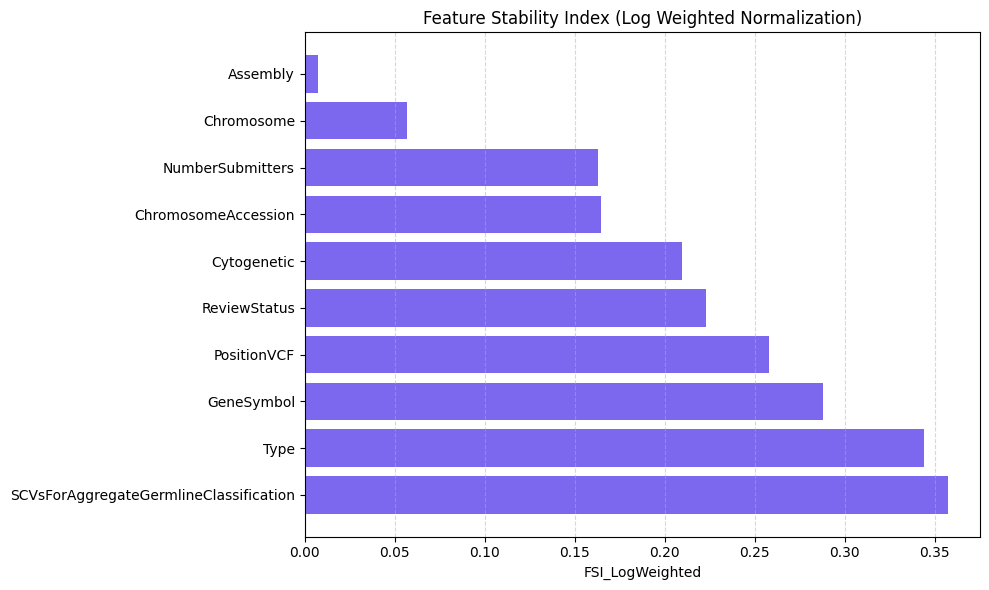

In [ ]:
import matplotlib.pyplot as plt
fsi_scores = {
    'SCVsForAggregateGermlineClassification': 0.357326,
    'Type': 0.343905,
    'ReviewStatus': 0.222768,
    'NumberSubmitters': 0.162913,
    'GeneSymbol': 0.288152,
    'PositionVCF': 0.258216,
    'Cytogenetic': 0.209873,
    'ChromosomeAccession': 0.164529,
    'Chromosome': 0.056824,
    'Assembly': 0.007472
}

# Sort by stability (lowest FSI first)
sorted_fsi = dict(sorted(fsi_scores.items(), key=lambda item: item[1]))

# Plot
plt.figure(figsize=(10, 6))
plt.barh(list(sorted_fsi.keys()), list(sorted_fsi.values()), color='mediumslateblue')
plt.xlabel('FSI_LogWeighted')
plt.title('Feature Stability Index (Log Weighted Normalization)')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd

# Number of splits
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Store FSI results per split
fsi_records = []

In [ ]:
for split_num, (train_idx, test_idx) in enumerate(skf.split(X, y_encoded)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]
    log_weighted_df = importance_df.drop(columns=['Feature']).copy()
    for col in log_weighted_df.columns:
        log_weighted_df[col] = np.log1p(np.maximum(log_weighted_df[col], 0))
        log_weighted_df[col] = (log_weighted_df[col] - log_weighted_df[col].min()) / (log_weighted_df[col].max() - log_weighted_df[col].min())
    importance_df['FSI_LogWeighted'] = log_weighted_df.std(axis=1)
    importance_df['Split'] = split_num
    fsi_records.append(importance_df[['Feature', 'FSI_LogWeighted', 'Split']].copy())

In [ ]:
# Combine all splits
fsi_all = pd.concat(fsi_records)

# Compute mean and std of FSI per feature
fsi_summary = fsi_all.groupby('Feature')['FSI_LogWeighted'].agg(['mean', 'std']).reset_index()
fsi_summary.columns = ['Feature', 'FSI_Mean', 'FSI_Std']

print("\n📊 Bootstrapped FSI Summary (Mean ± Std):")
for _, row in fsi_summary.iterrows():
    print(f"{row['Feature']}: {row['FSI_Mean']:.6f} ± {row['FSI_Std']:.6f}")


📊 Bootstrapped FSI Summary (Mean ± Std):
Assembly: 0.003610 ± 0.000000
Chromosome: 0.064074 ± 0.002088
ChromosomeAccession: 0.185771 ± 0.004917
Cytogenetic: 0.235808 ± 0.005752
GeneSymbol: 0.315498 ± 0.006001
NumberSubmitters: 0.157689 ± 0.001040
PositionVCF: 0.284445 ± 0.005767
ReviewStatus: 0.214807 ± 0.001382
SCVsForAggregateGermlineClassification: 0.241410 ± 0.000412
Type: 0.316671 ± 0.000518
